### RAGAS — RAG EVALUATION

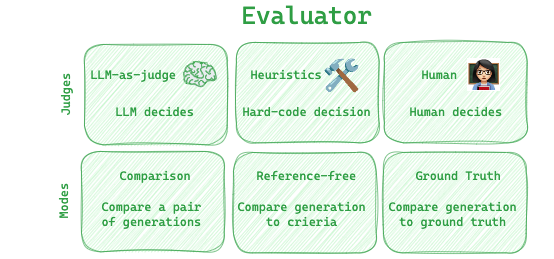

> Metrics available

**Evaluate the Retrieval (Indexing included)**

1. Context Precision
    - **Interpretation**: Measures how relevant and necessary the retrieved context is for answering the question. Higher scores indicate more precise context retrieval. This evaluates the tokens, evaluates the chunks and the order.
    - **Source**: https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/context_precision/

2. Context Recall
    - **Interpretation**: Calculates the recall of entities from the ground truth present in the retrieved context. A score of 1 indicates that all relevant entities are present in the context. The most important parameter, highly related to the factual correctness recall. Increasing the k in the retrieval until saturation. Also works with chunks. This evaluates the chunk with claims.
    - **Source**: https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/context_recall/ 

    NOTE: The retrieval is the first step in a RAG. Context Recall is the major metric in this step.

**Evaluate the Generation**

3. Noise Sensitivity
    - **Interpretation**: NoiseSensitivity measures how often a system makes errors by providing incorrect responses when utilizing either relevant or irrelevant retrieved documents. The score ranges from 0 to 1, with lower values indicating better performance. Noise sensitivity is computed using the user_input, reference, response, and the retrieved_contexts.
    - **Source**: https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/noise_sensitivity/ 

4. Faithfulness
    - **Interpretation**: Measures how factually consistent a response is with the retrieved context. It ranges from 0 to 1, with higher scores indicating better consistency.
    - **Source**: https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/faithfulness/ 

    NOTE: Hallucination = 100 - Faithfulness (the inverse)

**Overall Evaluation (end to end)**

5. Factual Correctness 
    - **Interpretation**: Metric that compares and evaluates the factual accuracy of generated response against the reference (ground truth). Determines if the generated response aligns with the reference. Depends on the Retrieval and the Generation.
    - **Source**: https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/factual_correctness/ 

    5.1. Factual Recall (This is the main metric. The model responds well in general with respect to the ground truth; penalizes lack of information)
    
    5.2. Factual Precision (to see if the model hallucinates or is very verbose; penalizes excess information)

6. Semantic Similarity (deterministic, less sensitive to RAG changes)
    - **Source**: https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/semantic_similarity/

### GUIDE — RAG IMPROVEMENT

> General improvements: Focus on the factual recall as the primary metric for improvement. This metric represents a major amount of correctly answered queries relative to the total Testset.

1. Improve Retrieval
    - **Improvement**: Focus on the context recall, which will lead to better factual recall by adjusting.

    - **Adjusting**: Parser, Indexing strategies, number of context (k), chunk size, embedding model.

2. Improve Generation 
   - **Improvement**: Aim to improve the faithfulness which will further enhance the factual recall

    - **Adjusting**: Generation model, system prompt, number of context (k)

NOTE: Vecto DB with homogenized chunks embed

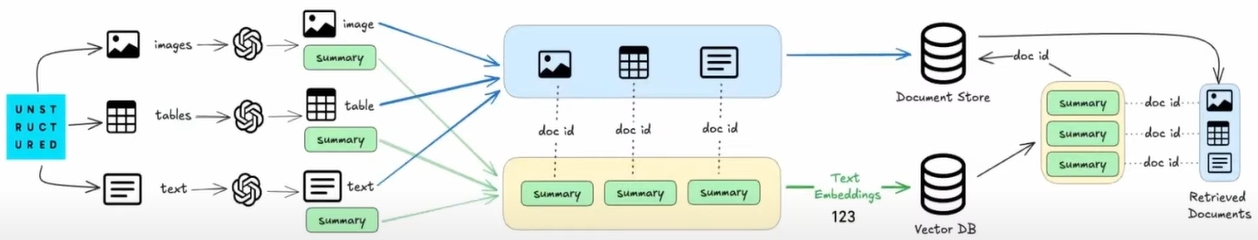

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

# Get the current research's directory
research_dir = os.path.dirname(os.path.abspath('__file__'))

# Move one directory back
parent_dir = os.path.dirname(research_dir)

# Change the current working directory to the parent directory
os.chdir(parent_dir)

# Print the current working directory to confirm
print(f"Current working directory: {os.getcwd()}")

In [3]:
from rageval.services.llm_services import LLMServices

# Define the Servives
llm = LLMServices.model
embeddings = LLMServices.embeddings
generator_llm = LLMServices.generator_llm
generator_embeddings = LLMServices.generator_embeddings
evaluator_llm = LLMServices.evaluator_llm

> Indexing: LOAD & SPLIT — Blob Container and Unstructured

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from azure.storage.blob import BlobServiceClient
from unstructured.partition.pdf import partition_pdf
import tempfile

# # Download PDF from Azure Blob Storage
# blob_service_client = BlobServiceClient.from_connection_string(CONN_STR)
# blob_client = blob_service_client.get_blob_client(container=CONTAINER, blob=BLOB_PDF)
# pdf_data = blob_client.download_blob().readall()

# # Create a temporary file
# with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as temp_file:
#     temp_file.write(pdf_data)
#     temp_file_path = temp_file.name

file_path = "artifacts/Memoria Técnica QUANTHIB_HAZITEK 2024.pdf"

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    # extract_image_block_types=["Image"], # Add 'Table' or 'Image' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    # extract_image_block_to_payload=True, # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=3000,                   # defaults to 500
    combine_text_under_n_chars=1000,       # defaults to 0
    new_after_n_chars=2000,
    
    # chunking_strategy="by_title",          # or 'basic'
    # max_characters=1000,                   # defaults to 500
    # combine_text_under_n_chars=500,        # defaults to 0
    # new_after_n_chars=500,
)

# # Clean up the temporary file
# os.unlink(temp_file_path)


In [ ]:
# We get 2 types of elements from the partition_pdf function
print(len(chunks))
set([str(type(el)) for el in chunks])

In [ ]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[3].metadata.orig_elements

In [8]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [ ]:
print('Tables:', len(tables))
print('Texts:', len(texts))

In [10]:
# Prompt for summarized the content
prompt_text = """
Eres un asistente encargado de resumir tablas y textos.
Proporciona un resumen conciso de la tabla o texto.

Responde solo con el resumen, sin comentarios adicionales.
No comiences tu mensaje diciendo "Aquí hay un resumen" o algo similar.
Simplemente proporciona el resumen tal cual.

Tabla o fragmento de texto: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
summarize_chain = {"element": lambda x: x} | prompt | llm | StrOutputParser()

In [11]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})


In [12]:
# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 2})

In [ ]:
text_summaries

> Indexing: EMBED & STORE — Load the summaries and link the to the original data

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embeddings)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [15]:
# Add texts summary
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

In [16]:
# Add tables summary
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

In [17]:
## Fast check the retrieve
docs = retriever.invoke(
    "¿Cuáles son los retos técnologicos más importantes del proyecto?"
)

In [ ]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

> RAG: RETRIEVAL AND GENERATION

In [19]:
from langchain_openai import AzureChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import END, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# Retrieve
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}

# Generation
def generate(state: State):
    prompt = ChatPromptTemplate.from_template(
        "Responde a la siguiente pregunta basándote en el contexto proporcionado:\n\n"
        "Contexto: {context}\n\n"
        "Pregunta: {question}\n\n"
        "Respuesta:"
    )
    
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# Crear el grafo
workflow = StateGraph(state_schema=State)

# Agregar nodos
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)

# Definir el flujo
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Compilar el grafo
graph = workflow.compile()


In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "¿Cuáles son los retos técnologicos más importantes del proyecto?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

### RAGAS - EVALUATION

>RAGAS: Testset Generation for RAG

NOTE: The TestDataset must contain the same doc of the RAG

In [4]:
# CREATE CHUNKS SMALLS TO BE PROCESSES AND LINKED IN A KNOWLEDGE GRAHPS TO GENERATE THE TESTSET
from unstructured.partition.pdf import partition_pdf

# Specify the folder path containing the PDF files
folder_path = "artifacts/rag_test_docs"

# Iterate through each file in the folder
chunks = []
for file in os.listdir(folder_path):
    
    file_path = os.path.join(folder_path, file)

    doc_chunks = partition_pdf(
        filename=file_path,
        infer_table_structure=True,            # extract tables
        strategy="hi_res",                     # mandatory to infer tables
        languages=["spa"],                     # set the main languages of the docs

        chunking_strategy="by_title",          # or 'basic'
        max_characters=3000,                   # defaults to 500
        combine_text_under_n_chars=1000,       # defaults to 0
        new_after_n_chars=2000,
    )
    chunks.extend(doc_chunks)

In [5]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [ ]:
from rageval.utils.common import unstructured_chunk_to_document

# Prepare the chunks docs to generate the Testset with ragas
text_docs = [unstructured_chunk_to_document(chunk) for chunk in texts]
table_docs = [unstructured_chunk_to_document(chunk) for chunk in tables]

docs = text_docs + table_docs
len(docs)

In [7]:
from rageval.components.ragas.multilanguage_systhesizers import MultiLanguageSynthesizer

distribution = {
    "SingleHopSpecific": 0.33, 
    "MultiHopSpecific": 0.33, 
    "MultiHopAbstract": 0.33,
}

config = {
    "adapt_query_distribution": True, 
    "language": "spanish", 
}
synthesizer = MultiLanguageSynthesizer(distribution=distribution, generator_llm=generator_llm, config=config)

# Adapt prompts
await synthesizer.adapt_prompts()

# Get distribution
distribution = synthesizer.get()

In [8]:
from rageval.components.ragas.people_groups import PeopleGroups

personas = PeopleGroups(default_group="Bantec People").get_group()

In [9]:
from rageval.components.ragas.custom_transforms import CustomTransforms

transforms = CustomTransforms(generator_llm, generator_embeddings).get()

In [10]:
from rageval.config.testsetgenerator_config import TestGeneratorConfig
from rageval.utils.common import read_yaml
from rageval.constants import *


config = read_yaml(CONFIG_FILE_PATH)

# Custom configuration
custom_config = TestGeneratorConfig(config=config).get()

In [ ]:
from ragas.testset import TestsetGenerator

# Generate Testset
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings, persona_list=personas)

dataset = generator.generate_with_langchain_docs(
    docs, 
    testset_size=10, 
    run_config=custom_config, 
    with_debugging_logs=True,
    transforms=transforms,
    query_distribution=distribution)

In [ ]:
testset = dataset.to_pandas()

testset = testset.drop_duplicates(subset=['user_input'], keep='first')

# Save the DataFrame to a CSV file
testset.to_csv('artifacts/outputs/testset.csv', index=False)

testset

>RAG Evaluation

NOTE: The model-base metrics with the evaluator (model-critic); should be better 'more intelligent' than the generator.

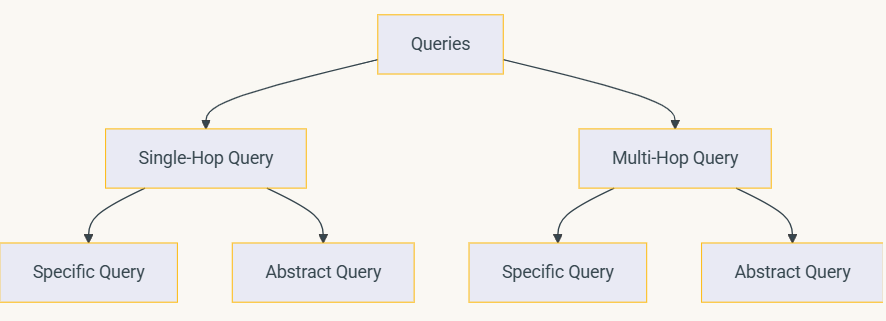

In [90]:
import pandas as pd
from langgraph.graph.graph import CompiledGraph
from langchain.schema.document import Document

def answerset(testset: pd.DataFrame, rag_model: CompiledGraph, to_csv: bool = True) -> pd.DataFrame:

    def _extract_page_contents(documents: List[Document]):
        return [doc.page_content for doc in documents]

    # Create a copy of the testset DataFrame to avoid modifying the original
    answerset = testset.copy()
    
    # Initialize empty lists for the new columns
    retrieved_contexts_list = []
    responses_list = []
    
    # Iterate through each row in the testset
    for _, row in testset.iterrows():
        user_input = row['user_input']
        
        # Get the retrieved context and response from the RAG model
        rag_output = rag_model.invoke({"question": user_input})
        retrieved_contexts = _extract_page_contents(rag_output["context"])
        response = rag_output["answer"]
        
        # Append the results to the lists
        retrieved_contexts_list.append(retrieved_contexts)
        responses_list.append(response)
    
    # Add the new columns to the answerset DataFrame
    answerset['retrieved_contexts'] = retrieved_contexts_list
    answerset['response'] = responses_list
    
    # Save to CSV if requested
    if to_csv:
        answerset.to_csv('../artifacts/answerset.csv', index=False)
    
    return answerset

In [91]:
answerset = answerset(testset, graph)

In [ ]:
import pandas as pd
import ast

# Read the CSV and convert specific columns to lists
answerset = pd.read_csv(
    'artifacts/outputs/answserset_12_202501271714.csv',
    converters={
        'reference_contexts': ast.literal_eval,
        'retrieved_contexts': ast.literal_eval
    }
)

# Check the data types and structure after loading
answerset.info()
print(answerset.head())


In [5]:
from ragas.metrics import (
    ContextPrecision,
    ContextRecall,
    NoiseSensitivity,
    Faithfulness,
    FactualCorrectness,
    SemanticSimilarity
)
from ragas.dataset_schema import SingleTurnSample
from ragas.metrics.base import MetricWithLLM
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
import pandas as pd

def metricset(answerset: pd.DataFrame, evaluator_llm: LangchainLLMWrapper, generator_embeddings: LangchainEmbeddingsWrapper, to_csv: bool = True) -> pd.DataFrame:
    
    # Create a copy of the answerset DataFrame
    metricset = answerset.copy()

    def get_metric_score(metric: MetricWithLLM, sample: SingleTurnSample):
        return metric.single_turn_score(sample)

    metrics = [
        ("context_precision", ContextPrecision(llm=evaluator_llm)),
        ("context_recall", ContextRecall(llm=evaluator_llm)),
        ("noise_sensitivity", NoiseSensitivity(llm=evaluator_llm)),
        ("faithfulness", Faithfulness(llm=evaluator_llm)),
        ("factual_correctness_recall", FactualCorrectness(llm=evaluator_llm, mode='recall', language='spanish')),
        ("factual_correctness_precision", FactualCorrectness(llm=evaluator_llm, mode='precision', language='spanish')),
        ("semantic_similarity", SemanticSimilarity(embeddings=generator_embeddings))
    ]

    for metric_name, metric in metrics:
        scores = []
        for _, row in metricset.iterrows():
            sample = SingleTurnSample(
                user_input=row['user_input'],
                response=row['response'],
                reference=row['reference'],
                retrieved_contexts=row['retrieved_contexts'],
                # reference_contexts=row['reference_contexts'] # NOTE: just needed for deterministic formulas
            )
            score = get_metric_score(metric, sample)
            scores.append(score)
        metricset[metric_name] = scores

    if to_csv:
        metricset.to_csv('artifacts/outputsmetricset.csv', index=False)

    return metricset
        

In [7]:
import multiprocessing
import pandas as pd
import time
from ragas.metrics import (
    ContextPrecision,
    ContextRecall,
    NoiseSensitivity,
    Faithfulness,
    FactualCorrectness,
    SemanticSimilarity
)
from ragas.dataset_schema import SingleTurnSample
from rageval.services.llm_services import LLMServices
from typing import Any, Dict
from openai import RateLimitError

def calculate_metrics(row: Dict[str, Any]):
    sample = SingleTurnSample(
        user_input=row['user_input'],
        response=row['response'],
        reference=row['reference'],
        retrieved_contexts=row['retrieved_contexts']
    )
    
    # Define the Services
    generator_embeddings = LLMServices.generator_embeddings
    evaluator_llm = LLMServices.evaluator_llm

    metrics = [
        ("context_precision", ContextPrecision(llm=evaluator_llm)),
        ("context_recall", ContextRecall(llm=evaluator_llm)),
        ("noise_sensitivity", NoiseSensitivity(llm=evaluator_llm)),
        ("faithfulness", Faithfulness(llm=evaluator_llm)),
        ("factual_correctness_recall", FactualCorrectness(llm=evaluator_llm, mode='recall', language='spanish')),
        ("factual_correctness_precision", FactualCorrectness(llm=evaluator_llm, mode='precision', language='spanish')),
        ("semantic_similarity", SemanticSimilarity(embeddings=generator_embeddings))
    ]
    
    results = []
    for _, metric in metrics:
        try:
            score = metric.single_turn_score(sample)  # Note: Using synchronous version
            results.append(score)
        except RateLimitError as e:
            print(f"RateLimitError: appending None")
            results.append(None)
    
    return results

def metricset_parallel(
    answerset: pd.DataFrame, 
    to_csv: bool = True
) -> pd.DataFrame:
    
    metricset = answerset.copy()

    # Use multiprocessing Pool
    with multiprocessing.Pool(processes=16) as pool:
        results = pool.map(calculate_metrics, metricset.to_dict('records'))

    # Define metrics names
    metric_names = [
        "context_precision",
        "context_recall",
        "noise_sensitivity",
        "faithfulness",
        "factual_correctness_recall",
        "factual_correctness_precision",
        "semantic_similarity"
    ]

    # Update the DataFrame with results
    for i, metric_name in enumerate(metric_names):
        metricset[metric_name] = [result[i] for result in results]

    if to_csv:
        metricset.to_csv('artifacts/outputs/metricset.csv', index=False)

    return metricset


In [ ]:
metrsicset = metricset_parallel(answerset)

In [9]:
import multiprocessing
import pandas as pd
import asyncio
from ragas.metrics import (
    ContextPrecision,
    ContextRecall,
    NoiseSensitivity,
    Faithfulness,
    FactualCorrectness,
    SemanticSimilarity
)
from ragas.dataset_schema import SingleTurnSample
from rageval.services.llm_services import LLMServices
from typing import Any, Dict
from openai import RateLimitError

async def calculate_metrics_async(row: Dict[str, Any]):
    sample = SingleTurnSample(
        user_input=row['user_input'],
        response=row['response'],
        reference=row['reference'],
        retrieved_contexts=row['retrieved_contexts']
    )
    
    # Define the Services
    generator_embeddings = LLMServices.generator_embeddings
    evaluator_llm = LLMServices.evaluator_llm

    metrics = [
        ("context_precision", ContextPrecision(llm=evaluator_llm)),
        ("context_recall", ContextRecall(llm=evaluator_llm)),
        ("noise_sensitivity", NoiseSensitivity(llm=evaluator_llm)),
        ("faithfulness", Faithfulness(llm=evaluator_llm)),
        ("factual_correctness_recall", FactualCorrectness(llm=evaluator_llm, mode='recall', language='spanish')),
        ("factual_correctness_precision", FactualCorrectness(llm=evaluator_llm, mode='precision', language='spanish')),
        ("semantic_similarity", SemanticSimilarity(embeddings=generator_embeddings))
    ]
    
    results = []
    for _, metric in metrics:
        try:
            score = await metric.single_turn_ascore(sample)  # Using asynchronous version
            results.append(score)
        except RateLimitError as e:
            print(f"RateLimitError: retrying in 60 seconds")
            await asyncio.sleep(60)
            score = await metric.single_turn_ascore(sample)  # Using asynchronous version
            results.append(score)

    return results

def calculate_metrics_wrapper(row):
    return asyncio.run(calculate_metrics_async(row))

def metricset_parallel(
    answerset: pd.DataFrame, 
    to_csv: bool = True
) -> pd.DataFrame:
    
    metricset = answerset.copy()

    # Use multiprocessing Pool
    with multiprocessing.Pool(processes=16) as pool:
        results = pool.map(calculate_metrics_wrapper, metricset.to_dict('records'))

    # Define metrics names
    metric_names = [
        "context_precision",
        "context_recall",
        "noise_sensitivity",
        "faithfulness",
        "factual_correctness_recall",
        "factual_correctness_precision",
        "semantic_similarity"
    ]

    # Update the DataFrame with results
    for i, metric_name in enumerate(metric_names):
        metricset[metric_name] = [result[i] for result in results]

    if to_csv:
        metricset.to_csv('artifacts/outputs/metricset.csv', index=False)

    return metricset



In [ ]:
metrsicset = metricset_parallel(answerset)

### ENDPOINT RAG TEST

Url -> https://aichatapp-web.happypebble-28661700.westeurope.azurecontainerapps.io/rag-eval/chat?input="input sin comillas"
 

{
"embeddings": [],
"finalResponse": ""
}
 

In [ ]:
import requests

url = os.getenv("API_RAG_ENDPOINT")
params = {"input": "¿Qué es HAZITEK?"}
headers = {os.getenv("API_RAG_HEADER_KEY"): os.getenv("API_RAG_HEADER_VALUE")}

response = requests.get(url, params=params, headers=headers)

print(response.status_code)
print(response.json())


In [ ]:
from rageval.utils.common import call_rag_api

call_rag_api("Qué es HAZITEK?")

In [ ]:
import pandas as pd

pd.read_csv("artifacts/outputs/metricset_12_202501251249.csv")